# 09. 基于MindSpore实现随机梯度下降

本实验主要介绍使用MindSpore开发随机梯度下降算法，并使用自定义数据训练和测试模型。

## 1、实验目的

- 了解并掌握随机梯度下降算法的原理。
- 掌握如何使用MindSpore进行随机梯度下降算法的开发。

## 2、随机梯度下降算法原理介绍

对于线性回归目标，使用最小二乘计算的损失函数：

$$J_{linreg}(\Theta)=J_{linreg}(w,b)=\frac{1}{n}\sum_{i=1}^{n}(w^Tx^{(i)}+b-y_i)^2$$
随机梯度下降算法是对标准下降算法的改进。为了后面计算起来简单，用$\Theta$表示w,b两个参数，或者用$\Theta$表示线性回归中所有的参数。
$$f(\Theta)=\frac{1}{n}\sum_{i=1}^{n}f_i(\Theta)$$
随机梯度下降的算法简写成SGD（Stochastic Gradient Descent），标准的梯度下降简称GD。其算法基本流程是：先对所有参数初始化。然后循环T次，每次从n个训练数据中随机抽取一个样本进行训练（可重复抽样）。训练按如下公式进行：
$$\Theta^{(t)}=\Theta^{(t-1)}-\eta(t)\nabla_{\Theta}f_i(\Theta^{(t-1)})$$
随机梯度下降与标准的梯度下降的区别在于两点：
1. 标准梯度下降的步长（$\eta$）是固定的，而随机梯度下降的步长是次数t的函数。
2. 标准梯度下降是对不同的点全部计算一遍，随机梯度下降是每次随机选取第i个样本进行训练。因此，每次随机梯度下降运算的结果可能不完全一样。
随机梯度下降常与小批量一同使用。批量算法是每次选一个mini batch 对其进行梯度下降，是对随机梯度下降的一点改进。标准梯度下降算法是每一步更新所有数据，再求平均。随机梯度下降只是选定一个点或者一小批量求它的梯度，效率比原来高。

## 3、实验环境


在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=2.4；Python环境=3.11。


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.4 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.4 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.4 Python3.11 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

## 4、数据处理

### 4.1数据准备

数据为自定义数据：x、y。
x、y均是MindSpore中的Tensor类。
x为所有数据在第一个维度上的值，y为所有数据在第二个维度上的值。
$$\begin{array}{l}
x=[55,71,68,87,101,87,75,78,93,73]\\
y=[91,101,87,109,129,98,95,101,104,93]\\
\end{array}
$$

### 4.2数据加载

x、y均是MindSpore中的Tensor类。
x为所有数据在第一个维度上的值，y为所有数据在第二个维度上的值。

In [1]:
# 导入库
# 科学计算库
import numpy as np
# 绘图
import matplotlib.pyplot as plt
# 张量
from mindspore import Tensor
import mindspore.ops as ops

In [2]:
x = np.array([55, 71, 68, 87, 101, 87, 75, 78, 93, 73])
y = np.array([91, 101, 87, 109, 129, 98, 95, 101, 104, 93])
# 将数据转换为Tensor类
x = Tensor(x.astype(np.float32))
y = Tensor(y.astype(np.float32))

## 5、模型构建

设置超参数

In [3]:
lr = 0.0001    #学习率
num_iter = 100 #迭代次数

直接算出线性回归解析解。

In [4]:
# 求解析解
# x：所有数据在第一个维度上的值
# y：所有数据在第二个维度上的值
def ols_algebra(x, y):
    n = len(x)
    # w1：一次项系数
    w1 = (n * ops.sum(x * y) - ops.sum(x) * ops.sum(y)) / (n * ops.sum(x * x) - ops.sum(x) * ops.sum(x))
    # w0：偏差
    w0 = (ops.sum(x * x) * ops.sum(y) - ops.sum(x) * ops.sum(x * y)) / (n * ops.sum(x * x) - ops.sum(x) * ops.sum(x))
    
    return w1, w0

通过最小二乘法定义梯度下降的算法过程。

In [5]:
# x：所有数据在第一个维度上的值
# y：所有数据在第二个维度上的值
# lr：学习率
# num_iter:迭代次数
def ols_gradient_descent(x, y, lr, num_iter):
    w1 = 0
    w0 = 0
    N = x.size
    for j in range(num_iter):
        for i in range(N):
            y_hat = (w1 * x[i]) + w0
            w1_gradient = -2 * (x[i] * (y[i] - y_hat))
            w0_gradient = -2 * (y[i] - y_hat)
            # w1：一次项系数
            w1 -= lr * w1_gradient
            # w0：偏差
            w0 -= lr * w0_gradient
    return w1, w0

## 6、模型训练

将数据带入解析解函数和随机梯度下降算法得到经过解析和最小二乘得到最终结果（两种算法得出的一次项系数和偏差）。

In [6]:
# 解析解结果
w1, w0 = ols_algebra(x, y)
# 随机梯度下降结果
w1_, w0_ = ols_gradient_descent(x, y, lr = lr, num_iter = num_iter)

两种方法训练集的预测结果和平方误差

In [7]:
y_hat_Analyse_train = x * w1 + w0
print("解析解训练集预测结果：", y_hat_Analyse_train)
L_Analyse_train = (y - y_hat_Analyse_train) ** 2
print("解析解训练集预测平方误差：", L_Analyse_train)

y_hat_SGD_train = x * w1_ + w0_
print("随机梯度下降训练集预测结果：", y_hat_SGD_train)
L_SGD_train = (y - y_hat_SGD_train) ** 2
print("随机梯度下降训练集预测平方误差：", L_SGD_train)

解析解训练集预测结果： [ 83.722     95.20301   93.05032  106.68402  116.7299   106.68402
  98.07326  100.22595  110.989395  96.63814 ]
解析解训练集预测平方误差： [ 52.969284    33.605087    36.606415     5.3637586  150.55544
  75.412224     9.444911     0.59915006  48.851643    13.236047  ]
随机梯度下降训练集预测结果： [ 71.15283   91.785904  87.9172   112.41897  130.4729   112.41897
  96.94417  100.81287  120.156364  94.365036]
随机梯度下降训练集预测平方误差： [3.9391006e+02 8.4899567e+01 8.4125251e-01 1.1689343e+01 2.1694355e+00
 2.0790665e+02 3.7797894e+00 3.5019055e-02 2.6102811e+02 1.8633233e+00]


## 7、模型预测

使用plot函数对梯度下降结果进行绘图

In [8]:
# 画图
# w1：解析解函数得出的一次项系数
# w0：解析解函数得出的偏差
# w1_：随机梯度下降算法得出的一次项系数
# w0_：随机梯度下降算法得出的偏差
# x：数据在第一个维度上的值
# y：数据在第二个维度上的值
# 要求画出两张图，第一张图上是数据散点图和y=w0*x+w1的图像，第二张图是数据散点图和y=w0_*x+w1_的图像
def plot_pic(w1, w0, w1_, w0_, x, y):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    w1 = w1.asnumpy()
    w0 = w0.asnumpy()
    w1_ = w1_.asnumpy()
    w0_ = w0_.asnumpy()
    x = x.asnumpy()
    y = y.asnumpy()
    # 解析解的图
    axes[0].scatter(x, y)
    axes[0].plot(np.array([50, 110]), np.array([50, 110]) * w1 + w0, 'r')
    axes[0].set_title('OLS')
    # 随机梯度下降的图
    axes[1].scatter(x, y)
    axes[1].plot(np.array([50, 110]), np.array([50, 110]) * w1_ + w0_, 'r')
    axes[1].set_title('Gradient descent')

    plt.show()

显示结果。

0.7175629
44.256042
1.2895666
0.2266687


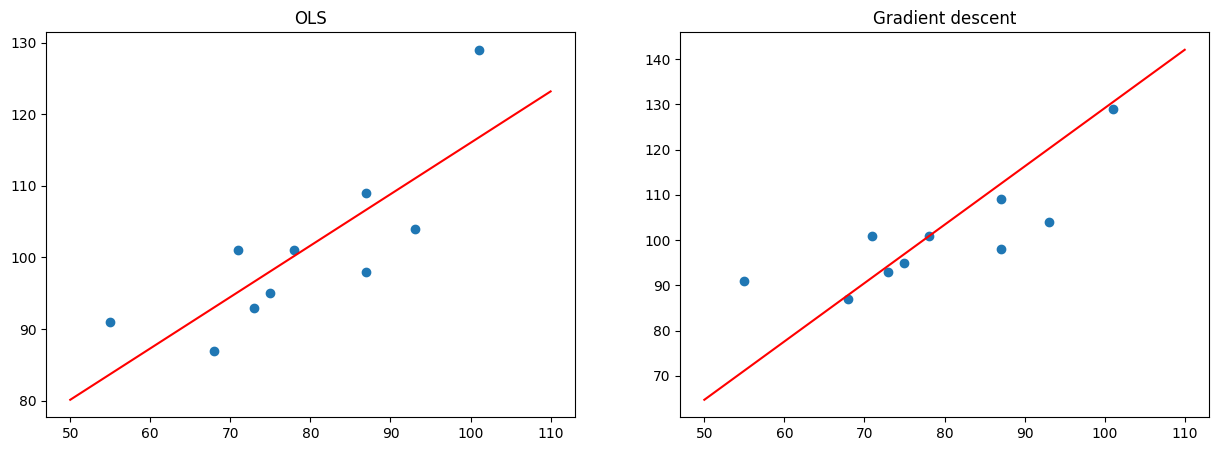

In [9]:
print(w1)  # w1：解析解函数得出的一次项系数
print(w0)  # w0：解析解函数得出的偏差
print(w1_) # w1_：随机梯度下降算法得出的一次项系数
print(w0_) # w0_：随机梯度下降算法得出的偏差
plot_pic(w1, w0, w1_, w0_, x, y)# 绘出两种算法的结果的图像

对于一个数据(92,100)计算其在两种算法下的平方误差。

In [10]:
#  测试数据
test_x = 92
test_y = 100
# 解析解预测值
y_hat_Analyse = w1 * test_x + w0
# 随机梯度下降预测值
y_hat_SGD = w1_ * test_x + w0_
# 解析解方法平方误差
L_Analyse = (y_hat_Analyse - test_y) ** 2
# 随机梯度下降平方误差
L_SGD = (y_hat_SGD - test_y) ** 2

print("对于（92，100）数据\n")
print("解析解方法预测值：",y_hat_Analyse," 其平方误差为：",L_Analyse,"\n")
print("随机梯度下降方法预测值：",y_hat_SGD," 其平方误差为：",L_SGD,"\n")

对于（92，100）数据

解析解方法预测值： 110.27183  其平方误差为： 105.510445 

随机梯度下降方法预测值： 118.8668  其平方误差为： 355.9561 

